In [203]:
import json, os
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from bs4 import BeautifulSoup
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path_to_json = 'howest_dataset/'
dataset= pd.DataFrame()
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

for json_file in json_files:
    json_file=path_to_json+json_file
    with open(json_file) as train_file:
        dict_train = json.load(train_file)
    file_df=pd.DataFrame.from_dict(pd.json_normalize(dict_train), orient='columns')
    dataset=dataset.append(file_df,ignore_index = True)

In [4]:
dataset.head(1000)

,language,client_reference,mail_subject,mail_content,party_id,party_type,unit_id,organization,from_mail,comments,attachments,labels.assignment_type,labels.case_type,labels.sub_case_type,labels.damage_type
0,fr_BE,20GB703550,nouvelle mission Concerne le sinistre no. *C3...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116443,P&V Groep,info@vancleemputsprl.be,Claims BA Antwerpen,[{'filename': 'VIVIUM GL C301909620 C36 Inspec...,Bilateral,Liability,Operations,Other_DamageType
1,nl_BE,21200109301,MISSION_ASSIGNEMENT: NSN21200109301,in bijlage <anon> wij een document met betrekk...,21955048183443173,nonNaturalPerson,24206847997116432,Allianz,NoReplyECNM@allianz.be,Beheer,"[{'filename': 'MISSION_ASSIGNEMENT.pdf', 'cont...",Unilateral,Property,Fire,WaterDamage
2,nl_BE,C101920102,Betreft het schadegeval nr. *C101920102* van 0...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116437,P&V Groep,claims-auto@pv.be,Claims-Auto,"[{'filename': 'Copie police.pdf', 'content': '...",Bilateral,Liability,Familial,Collision
3,nl_BE,C101981609,Betreft het schadegeval nr. *C101981609* van 2...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116440,P&V Groep,claims-auto-ant@vivium.be,Claims Auto Antwerpen,"[{'filename': 'Vonnis dronkenschap.pdf', 'cont...",Unilateral,Investigation,BA_Auto,Solvency
4,nl_BE,C101994565,Betreft het schadegeval nr. *C101994565* van 2...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116440,P&V Groep,claims-auto-ant@vivium.be,Claims Auto Antwerpen,"[{'filename': 'BVS AXA versie tp.pdf', 'conten...",Unilateral,Investigation,BA_Auto,Statement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,nl_BE,C302008411,Betreft het schadegeval nr. *C302008411* van 2...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116443,P&V Groep,claims-BA-ANT@vivium.be,Claims BA Antwerpen,"[{'filename': 'Polis.pdf', 'content': 'histori...",Bilateral,Liability,Operations,WaterDamage
996,nl_BE,C302008414,Betreft het schadegeval nr. *C302008414* van 2...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116443,P&V Groep,claims-BA-ANT@vivium.be,Claims BA Antwerpen,"[{'filename': '25 Brief Beheer.pdf', 'content'...",Bilateral,Liability,Operations,WaterDamage
997,nl_BE,C302008418,Betreft het schadegeval nr. *C302008418* van 2...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116443,P&V Groep,claims-BA-ANT@vivium.be,Claims BA Antwerpen,"[{'filename': '10 OM BA.pdf', 'content': 'antw...",Bilateral,Liability,Operations,Other_DamageType
998,nl_BE,C302008419,Betreft het schadegeval nr. *C302008419* van 3...,<anon> <anon> <anon> <anon> <anon> <anon> <ano...,21955048183443174,nonNaturalPerson,24206847997116443,P&V Groep,claims-BA-ANT@vivium.be,Claims BA Antwerpen,[{'filename': 'VIVIUM GL C302008419 C36 Inspec...,Bilateral,Liability,Operations,WaterDamage


In [5]:
dataset.drop(['client_reference','mail_subject','party_id','party_type','unit_id','organization','from_mail','comments'], axis=1, inplace=True) 

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   language                3673 non-null   object
 1   mail_content            3673 non-null   object
 2   attachments             3673 non-null   object
 3   labels.assignment_type  3673 non-null   object
 4   labels.case_type        3673 non-null   object
 5   labels.sub_case_type    3673 non-null   object
 6   labels.damage_type      3673 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB


In [7]:
def text_processing(content):
    text_no_html = BeautifulSoup(str(content),"html.parser" ).get_text()
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
    text_lower = text_alpha_chars.lower()
    return text_lower

def get_fileNames(attachment):
    fileNames=[]
    for obj in attachment:
        fileNames.append(obj['filename'].replace('.pdf', ''))
        fileNamesStr = ' '.join(fileNames)
    return fileNamesStr

def get_content(attachment):
    contents=[]
    for obj in attachment:
        contents.append(obj['content'])
        contentsStr = ' '.join(contents)
        contentsStr=text_processing(contentsStr)
    return contentsStr
    
dataset['mail_content']=dataset['mail_content'].apply(text_processing)
dataset['attachments_filename']=dataset['attachments'].apply(get_fileNames)
dataset['attachments_content']=dataset['attachments'].apply(get_content)
dataset.drop('attachments', axis=1, inplace=True) 

In [45]:
#dataset_nl = pd.DataFrame()
dataset_nl=dataset.loc[dataset['language']=='nl_BE']
dataset_fr=dataset.loc[dataset['language']=='fr_BE']

In [46]:
dataset.head(1000)

,language,mail_content,labels.assignment_type,labels.case_type,labels.sub_case_type,labels.damage_type,attachments_filename,attachments_content
0,fr_BE,b br b mardi septembre b...,Bilateral,Liability,Operations,Other_DamageType,VIVIUM GL C301909620 C36 Inspection - DM 2020-...,en cas de dommage materiel si ge rue royal...
1,nl_BE,in bijlage wij een document met betrekking to...,Unilateral,Property,Fire,WaterDamage,MISSION_ASSIGNEMENT mail makelaar - aangifte w...,nv koning bic btw be verze...
2,nl_BE,sans mevrouw contacteren ...,Bilateral,Liability,Familial,Collision,Copie police 43 Recours pour la franchise cont...,from sent tue mar to subject ...
3,nl_BE,sans mevrouw contacteren ...,Unilateral,Investigation,BA_Auto,Solvency,Vonnis dronkenschap 52a-verhaal VIVIUM AUTO C1...,afdellng kortrijk jul antwerpen juli ...
4,nl_BE,sans mevrouw contacteren ...,Unilateral,Investigation,BA_Auto,Statement,BVS AXA versie tp VIVIUM AUTO C101994565 C36 I...,opdracht materiele schade zetel exper...
...,...,...,...,...,...,...,...,...
995,nl_BE,sans mevrouw contacteren ...,Bilateral,Liability,Operations,WaterDamage,Polis 0848958_10-30-2020_320073466 VIVIUM GL C...,historiek op num contract ris num beschrijv...
996,nl_BE,sans mevrouw contacteren ...,Bilateral,Liability,Operations,WaterDamage,25 Brief Beheer 10 OM BA polis v exp TP bestek...,november van naam afdeling afde...
997,nl_BE,sans mevrouw contacteren ...,Bilateral,Liability,Operations,Other_DamageType,10 OM BA polis bestek aangifte VIVIUM GL C3020...,antwerpen november kortrijk goor naa...
998,nl_BE,sans mevrouw contacteren ...,Bilateral,Liability,Operations,WaterDamage,VIVIUM GL C302008419 C36 Inspectie - MS 2020-1...,opdracht materiele schade zetel expert...


In [185]:
dataset_nl=dataset_nl[["language","mail_content","attachments_filename","attachments_content","labels.assignment_type","labels.case_type","labels.sub_case_type","labels.damage_type"]]
dataset_nl.head()

language  \
1    nl_BE   
2    nl_BE   
3    nl_BE   
4    nl_BE   
5    nl_BE   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                mail_content  \
1  in bijlage  wij een document met betrekking tot een opdracht dat toevertrouwd werd in het  van de verdediging van onze belangen  the present electronic message and all the information it  inclusive of any  document are  confidential and are   for the  if you are not an   you must not open use duplicate this message nor  the contents to any third party if the case would happen we  invite you to destroy the present e mail and to inform the  at once  total safety confidentiality and  of electronic messages can by no means be  the  can  not be held  for damage   the use of e mail such as virus contamination and interception or  of transmissions    
2                                                                                                                                                                                                                                                                                                                                                         sans          mevrouw    contacteren als verzekeraar van    bijlage vindt een bericht naar aanleiding van een  waarbij  betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
3                                                                                                                                                                                                                                                                                                                                              sans          mevrouw    contacteren als verzekeraar van     bijlage vindt een bericht naar aanleiding van een  waarbij  construct betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
4                                                                                                                                                                                                                                                                                                                                                         sans          mevrouw    contacteren als verzekeraar van    bijlage vindt een bericht naar aanleiding van een  waarbij  betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
5                                                                                                                                                                                                                                                                                                                                                               sans          mevrouw    contacteren als verzekeraar     bijlage vindt een bericht naar aanleiding  een  waarbij  betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten b

<AxesSubplot:xlabel='labels.damage_type', ylabel='count'>

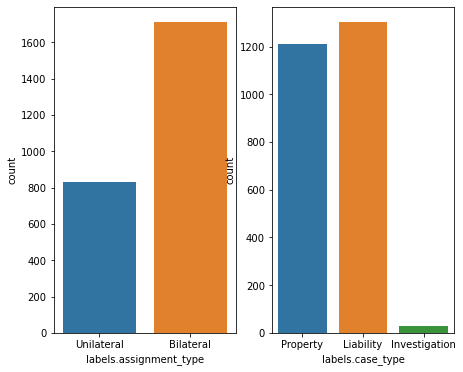

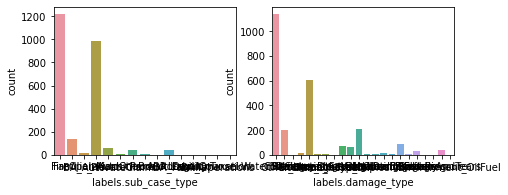

In [186]:
plt.figure(1 , figsize = (15 , 6))

plt.subplot(1 , 4 , 1)
sns.countplot(x="labels.assignment_type",data=dataset_nl)
plt.subplot(1 , 4 , 2)
sns.countplot(x="labels.case_type",data=dataset_nl)

plt.figure(2 , figsize = (15 , 6))
plt.subplot(2 , 4 , 1)
sns.countplot(x="labels.sub_case_type",data=dataset_nl)
plt.subplot(2 , 4 , 2)
sns.countplot(x="labels.damage_type",data=dataset_nl)

In [187]:
X_train_nl = dataset_nl[['mail_content','attachments_filename','attachments_content']]
y_train_nl = dataset_nl[["labels.assignment_type", "labels.case_type" , "labels.sub_case_type", "labels.damage_type"]]
#y_train_nl
X_train_nl


mail_content  \
1          in bijlage  wij een document met betrekking tot een opdracht dat toevertrouwd werd in het  van de verdediging van onze belangen  the present electronic message and all the information it  inclusive of any  document are  confidential and are   for the  if you are not an   you must not open use duplicate this message nor  the contents to any third party if the case would happen we  invite you to destroy the present e mail and to inform the  at once  total safety confidentiality and  of electronic messages can by no means be  the  can  not be held  for damage   the use of e mail such as virus contamination and interception or  of transmissions    
2                                                                                                                                                                                                                                                                                                                                                                 sans          mevrouw    contacteren als verzekeraar van    bijlage vindt een bericht naar aanleiding van een  waarbij  betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
3                                                                                                                                                                                                                                                                                                                                                      sans          mevrouw    contacteren als verzekeraar van     bijlage vindt een bericht naar aanleiding van een  waarbij  construct betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
4                                                                                                                                                                                                                                                                                                                                                                 sans          mevrouw    contacteren als verzekeraar van    bijlage vindt een bericht naar aanleiding van een  waarbij  betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
5                                                                                                                                                                                                                                                                                                                                                                       sans          mevrouw    contacteren als verzekeraar     bijlage vindt een bericht naar aanleiding  een  waarbij  betrokken    wij vragen gevolg te geven aan dit bericht br   meer informatie wenst of nog vragen hebt kunt contact opnemen met    bedankt voor uw    vriendelijke groeten br    br           
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ...   


In [188]:
X_train_nl=X_train_nl.drop(['mail_content','attachments_filename','attachments_content'],axis=1)

In [189]:
X_train_nl['content']=dataset[dataset.columns[1:]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)
pd.set_option("display.max_colwidth", -1)
display(X_train_nl)

<ipython-input-189-a1f9eacd4371>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


content
1     in bijlage  wij een document met betrekking tot een opdracht dat toevertrouwd werd in het  van de verdediging van onze belangen  the present electronic message and all the information it  inclusive of any  document are  confidential and are   for the  if you are not an   you must not open use duplicate this message nor  the contents to any third party if the case would happen we  invite you to destroy the present e mail and to inform the  at once  total safety confidentiality and  of electronic messages can by no means be  the  can  not be held  for damage   the use of e mail such as virus contamination and interception or  of transmissions  Unilateral Property Fire WaterDamage MISSION_ASSIGNEMENT mail makelaar - aangifte waterschade foto dakgoot foto dak foto buis buiten foto foto dak dossier NSN212001093 - schade door vorst mail Verzekerde tekening oorzaak bestek € 5.869 incl btw  verklaring Verzekerde uitleg cl waar buis loopt    nv koning            bic   btw  be     verzekeringsmaatschappij toegelaten door de nbb  bank van  onder codenummer  om alle   en  te beoefenen  de        experts     sint stevens    maart  uw contact     e mail        onze referte   opdracht  expertise materieel waterschade beste medewerker betreft een expertise met betrekking tot het  van   onze verzekerde   adres verzekerde     ligging risico  niet van toepassing ligging schade     contract  schade nummer   type contract  brand woning makelaar    bvba   in het  van deze opdracht vragen wij het volgende  onderzoeken van oorzaak en omstandigheden evaluatie van de schade foto's nemen  van toepassing voor deze opdracht         bijgevoegd vindt bijkomende informatie aangaande het  we ontvangen graag de bevestiging van uw aanvaarding van deze opdracht tegen  als nog vragen heeft aarzel dan niet om ons te contacteren  met vriendelijke groeten   team back office motor bescherming van persoonsgegevens   verzamelt persoonsgegevens om  op te stellen te beheren en uit te voeren wij gebruiken die gegevens in het bijzonder in het  van de relaties met onze partners en voor specifieke doeleinden de persoonsgegevens worden verwerkt in overeenstemming met de wetgeving inzake de bescherming van persoonsgegevens en de wetten die van toepassing zijn op verzekeringen die gegevens worden met gedeeld voor zover ze absoluut nodig hebt om de opdracht uit te voeren die  toevertrouwt  verwacht van zijn partners dat zij  toepassen die in overeenstemming zijn met de professionele goede praktijken de gegevens mogen in geen geval worden gebruikt voor andere doeleinden dan die van de opdracht noch langer worden bewaard dan noodzakelijk voor de verwerking of dan wettelijk vereist na die periode moet de gegevens teruggeven aan de maatschappij of ze vernietigen meer uitleg over ons beleid inzake de bescherming van persoonsgegevens vindt op onze website    from    date   februari     to   subject  ext polis  onze ref  geachte wij verwijzen naar in referte vermelde polis  betreft nieuwe aangifte  datum  als bijlage vindt aangifte van de klant fotos gelieve een dossier te openen en uw  te bezorgen  met vriendelijke groeten  van loon kantoormedewerker t   e      bvba dokter      this message and any    is   for the  and is confidential  if you  this message in error please delete it and   the  any use not in accord with its  any reproduction  modification   or publication  whole or partial is  except formal  the internet can not  the  of this message  n v and its  do not  the  of the message and the  of its content and shall  not  be  from  that may  from the  of this message or if it has been modified   or infected with virus  do not print this message  it is   the   general e mail information  from    to   subject ext polis  onze ref  date         of categories    a   a   a   a   a   a   a   a  description a these documents are  to pdf b these documents are  to pdf the original file is also  to the pdf a these documents are  in original format b container page is  and t

In [212]:

pd.set_option('display.max_colwidth', None)
X_train_nl.head(1)


content
1  in bijlage  wij een document met betrekking tot een opdracht dat toevertrouwd werd in het  van de verdediging van onze belangen  the present electronic message and all the information it  inclusive of any  document are  confidential and are   for the  if you are not an   you must not open use duplicate this message nor  the contents to any third party if the case would happen we  invite you to destroy the present e mail and to inform the  at once  total safety confidentiality and  of electronic messages can by no means be  the  can  not be held  for damage   the use of e mail such as virus contamination and interception or  of transmissions  Unilateral Property Fire WaterDamage MISSION_ASSIGNEMENT mail makelaar - aangifte waterschade foto dakgoot foto dak foto buis buiten foto foto dak dossier NSN212001093 - schade door vorst mail Verzekerde tekening oorzaak bestek € 5.869 incl btw  verklaring Verzekerde uitleg cl waar buis loopt    nv koning            bic   btw  be     verzekeringsmaatschappij toegelaten door de nbb  bank van  onder codenummer  om alle   en  te beoefenen  de        experts     sint stevens    maart  uw contact     e mail        onze referte   opdracht  expertise materieel waterschade beste medewerker betreft een expertise met betrekking tot het  van   onze verzekerde   adres verzekerde     ligging risico  niet van toepassing ligging schade     contract  schade nummer   type contract  brand woning makelaar    bvba   in het  van deze opdracht vragen wij het volgende  onderzoeken van oorzaak en omstandigheden evaluatie van de schade foto's nemen  van toepassing voor deze opdracht         bijgevoegd vindt bijkomende informatie aangaande het  we ontvangen graag de bevestiging van uw aanvaarding van deze opdracht tegen  als nog vragen heeft aarzel dan niet om ons te contacteren  met vriendelijke groeten   team back office motor bescherming van persoonsgegevens   verzamelt persoonsgegevens om  op te stellen te beheren en uit te voeren wij gebruiken die gegevens in het bijzonder in het  van de relaties met onze partners en voor specifieke doeleinden de persoonsgegevens worden verwerkt in overeenstemming met de wetgeving inzake de bescherming van persoonsgegevens en de wetten die van toepassing zijn op verzekeringen die gegevens worden met gedeeld voor zover ze absoluut nodig hebt om de opdracht uit te voeren die  toevertrouwt  verwacht van zijn partners dat zij  toepassen die in overeenstemming zijn met de professionele goede praktijken de gegevens mogen in geen geval worden gebruikt voor andere doeleinden dan die van de opdracht noch langer worden bewaard dan noodzakelijk voor de verwerking of dan wettelijk vereist na die periode moet de gegevens teruggeven aan de maatschappij of ze vernietigen meer uitleg over ons beleid inzake de bescherming van persoonsgegevens vindt op onze website    from    date   februari     to   subject  ext polis  onze ref  geachte wij verwijzen naar in referte vermelde polis  betreft nieuwe aangifte  datum  als bijlage vindt aangifte van de klant fotos gelieve een dossier te openen en uw  te bezorgen  met vriendelijke groeten  van loon kantoormedewerker t   e      bvba dokter      this message and any    is   for the  and is confidential  if you  this message in error please delete it and   the  any use not in accord with its  any reproduction  modification   or publication  whole or partial is  except formal  the internet can not  the  of this message  n v and its  do not  the  of the message and the  of its content and shall  not  be  from  that may  from the  of this message or if it has been modified   or infected with virus  do not print this message  it is   the   general e mail information  from    to   subject ext polis  onze ref  date         of categories    a   a   a   a   a   a   a   a  description a these documents are  to pdf b these documents are  to pdf the original file is also  to the pdf a these documents are  in original format b container page is  and the 

# LSTM1
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [213]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train_nl['content'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 42726 unique tokens.


In [214]:
X = tokenizer.texts_to_sequences(X_train_nl['content'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2541, 250)


In [215]:
print(y_train_nl.shape)
y = pd.get_dummies(y_train_nl)
print('Shape of label tensor:', y.shape)

(2541, 4)
Shape of label tensor: (2541, 42)


In [216]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1778, 250) (1778, 42)
(763, 250) (763, 42)


In [225]:
# Text filter

def text_preprocessing(text):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words('dutch')+stopwords.words('french')+stopwords.words('english')) 
    #stops_fr = set(stopwords.words('french')) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    #text_stemmer = ' '
    #stemmer_nl = SnowballStemmer('dutch')
    #stemmer_fr = SnowballStemmer('french')
    #for w in text_no_stop_words.split():
    #    text_no_short_words = text_stemmer + stemmer_nl.stem(w) + ' '
    #    text_no_short_words = text_stemmer + stemmer_fr.stem(w) + ' '
    #     
 

    return text_no_stop_words

In [227]:
# Convert training and test set to bag of words
for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i])
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i])

444500


ValueError: invalid literal for int() with base 10: ' '

In [200]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.4))
model.add(Dense(42, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
25/25 [==============================] - 13s 205ms/step - loss: 14.2148 - accuracy: 0.3435 - val_loss: 10.9025 - val_accuracy: 0.6236
Epoch 2/5
25/25 [==============================] - 3s 109ms/step - loss: 10.7851 - accuracy: 0.6860 - val_loss: 10.9580 - val_accuracy: 0.6236
Epoch 3/5
25/25 [==============================] - 3s 109ms/step - loss: 10.9838 - accuracy: 0.6865 - val_loss: 11.0979 - val_accuracy: 0.6236
Epoch 4/5
25/25 [==============================] - 3s 109ms/step - loss: 11.1316 - accuracy: 0.6673 - val_loss: 11.2309 - val_accuracy: 0.6236


In [207]:
y_pred = model.predict(X_test)
    
for y_pre in y_pred:
    pred=(y_pre>0.5).astype(np.float32)
    print(pred)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [208]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

24/24 [==============================] - 1s 22ms/step - loss: 11.0066 - accuracy: 0.6658
Test set
  Loss: 11.007
  Accuracy: 0.666


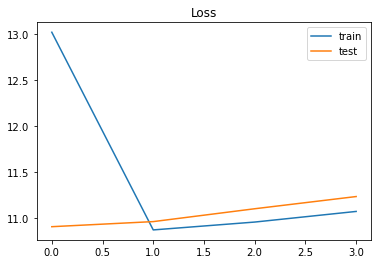

In [209]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

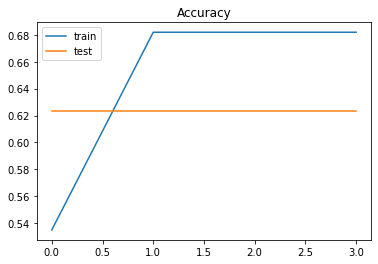

In [210]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# LSTM2
https://github.com/ferrygun/Multiclass_LSTM/blob/master/Multiclass_LSTM.ipynb

In [173]:

vocab_size = 50000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #OOV = Out of Vocabulary
training_portion = .8

In [174]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_nl,y_train_nl, test_size = 0.3, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1778, 3) (1778, 4)
(763, 3) (763, 4)


In [175]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [176]:
train_sequences = tokenizer.texts_to_sequences(X_train)

# Dataset_fr

In [12]:
dataset_fr=dataset_fr[["language","mail_content","attachments_filename","attachments_content","labels.assignment_type","labels.case_type","labels.sub_case_type","labels.damage_type"]]
dataset_fr.head()

,language,mail_content,attachments_filename,attachments_content,labels.assignment_type,labels.case_type,labels.sub_case_type,labels.damage_type
0,fr_BE,b br b mardi septembre b...,VIVIUM GL C301909620 C36 Inspection - DM 2020-...,en cas de dommage materiel si ge rue royal...,Bilateral,Liability,Operations,Other_DamageType
6,fr_BE,sans vous contactons en q...,INT tiers mise en demeure PV AUTO C102012228 ...,for healthy from claims team sent mo...,Unilateral,Property,Fire,Vandalism
7,fr_BE,sans mevrouw contacteren ...,voir note !SIN DU 11420 decl du tiers !!! 15 M...,from sent tue apr to subject ...,Unilateral,Investigation,BA_Auto,Statement
9,fr_BE,sans vous contactons en q...,docs Collignon4 compressé docs Collignon3 docs...,um juillet dis rue du pont neuf pour ...,Bilateral,Liability,Auto,Collision
14,fr_BE,sans mevrouw contacteren ...,décla 15 Mise en demeure rappel mise en demeur...,from sent mon jul to cc subje...,Unilateral,Property,_PrivateClaim,Other_DamageType
